In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [4]:
figsize=(20, 5)
plt.style.use('ggplot')

In [5]:
data = pd.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

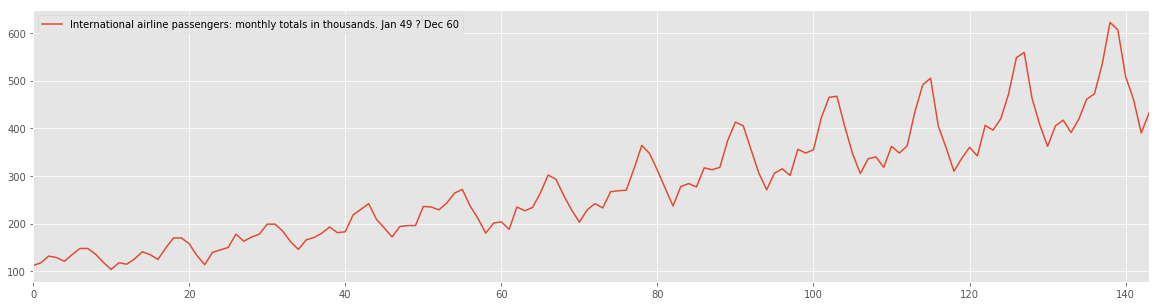

In [6]:
data.plot(figsize=figsize)

In [7]:
dataset = data.values
dataset = dataset.astype('float32')

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scale_dataset = scaler.fit_transform(dataset)

In [12]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
scale_train, scale_test = scale_dataset[0:train_size,:], scale_dataset[train_size:len(scale_dataset),:]
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# fix me
train = scale_train
test = scale_test
dataset = scale_dataset

# Train Loop

In [10]:
class TrainContext(object):
    def __init__(self, dataset, trainX, trainY, testX, testY):
        self.dataset = dataset
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
    
def train_model(dataset, look_back):
    # split into train and test sets
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=32, batch_size=1, verbose=2)
    
    return model, TrainContext(dataset, trainX, trainY, testX, testY)

# Train With Scaling

In [11]:
m, ctx = train_model(scale_dataset, 1)

Epoch 1/32
1s - loss: 0.0508
Epoch 2/32
0s - loss: 0.0240
Epoch 3/32
0s - loss: 0.0178
Epoch 4/32
0s - loss: 0.0163
Epoch 5/32
0s - loss: 0.0151
Epoch 6/32
0s - loss: 0.0141
Epoch 7/32
0s - loss: 0.0132
Epoch 8/32
0s - loss: 0.0123
Epoch 9/32
0s - loss: 0.0114
Epoch 10/32
0s - loss: 0.0105
Epoch 11/32
0s - loss: 0.0095
Epoch 12/32
0s - loss: 0.0088
Epoch 13/32
0s - loss: 0.0079
Epoch 14/32
0s - loss: 0.0073
Epoch 15/32
0s - loss: 0.0064
Epoch 16/32
0s - loss: 0.0057
Epoch 17/32
0s - loss: 0.0051
Epoch 18/32
0s - loss: 0.0045
Epoch 19/32
0s - loss: 0.0039
Epoch 20/32
0s - loss: 0.0034
Epoch 21/32
0s - loss: 0.0030
Epoch 22/32
0s - loss: 0.0027
Epoch 23/32
0s - loss: 0.0025
Epoch 24/32
0s - loss: 0.0023
Epoch 25/32
0s - loss: 0.0022
Epoch 26/32
0s - loss: 0.0021
Epoch 27/32
0s - loss: 0.0021
Epoch 28/32
0s - loss: 0.0021
Epoch 29/32
0s - loss: 0.0020
Epoch 30/32
0s - loss: 0.0020
Epoch 31/32
0s - loss: 0.0020
Epoch 32/32
0s - loss: 0.0021


In [14]:
help(scaler.inverse_transform)

Help on method inverse_transform in module sklearn.preprocessing.data:

inverse_transform(X) method of sklearn.preprocessing.data.MinMaxScaler instance
    Undo the scaling of X according to feature_range.
    
    Parameters
    ----------
    X : array-like, shape [n_samples, n_features]
        Input data that will be transformed. It cannot be sparse.



# CUT HERE

In [12]:
# make predictions
trainPredict = m.predict(ctx.trainX)
testPredict = m.predict(ctx.testX)

In [13]:
(trainPredict.shape, testPredict.shape)

((94, 1), (46, 1))

In [14]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([ctx.trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([ctx.testY])

In [15]:
def plot_predict(dataset, look_back):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

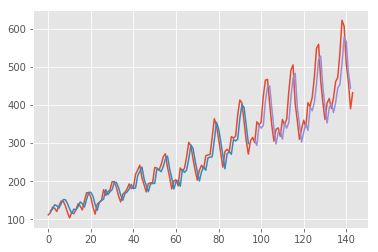

In [16]:
plot_predict(ctx.dataset, 1)